In [5]:
# # GOOGLE COLAB
import os
from google.colab import drive
drive.mount('/content/drive')
# change working directory if not done already
if os.getcwd().split('/')[-2] != 'My Drive':
  os.chdir('drive/MyDrive/laba')

Mounted at /content/drive


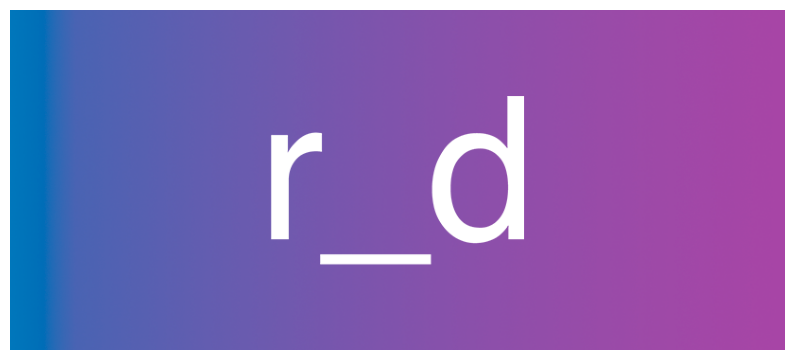

In [6]:
import rd_utils as rdu
rdu.show_logo()

<font size="10">Lekce 10 - domácí úloha</font>

<font size="6">Multiclass classification, model ensembles</font>

- Budeme procvičovat převážně látku z lekce 9.
- V následující úloze natrénujeme dva modely na datasetu `diamonds`.
- Tentoktát nebudeme predikovat cenu, ale hodnotu proměnné `cut`.
- Bude se tak jednat o multiclass classification problém.
- Vedle rozhodovacího stromu použijete i jednu z ensemble metod - LightGBM
- Velká část úkolu je věnována vyhodnocení multiclass klasifikace, a to pomocí matice záměn, classification reporu, ROC AUC skóre či ROC křivky

# Housekeeping

In [7]:
pip install sklearn.preprocessing

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix, roc_curve, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, RobustScaler
# from sklearn.preprocessing import TargetEncoder mi hadže error
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_validate, ShuffleSplit, KFold,  GridSearchCV, RandomizedSearchCV

In [9]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Načtení dat

In [10]:
diamonds_raw = pd.read_csv('datasets/diamonds/diamonds.csv')

In [11]:
diamonds_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


In [12]:
diamonds_raw.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


 - "carat": Hmotnost diamantu v karátech. Karát je jednotkou hmotnosti pro drahokamy, přičemž 1 karát je rovno 0,2 gramu.
 - "cut": Kvalita brusu diamantu. Hodnoty mohou být "Fair" (nepravidelný brus), "Good" (dobrý brus), "Very Good" (velmi dobrý brus), "Premium" (prestižní brus) nebo "Ideal" (ideální brus).
 - "color": Barva diamantu. Hodnoty se označují písmeny od "D" (nejčistší a nejbílejší) až po "Z" (nejžlutější).
 - "clarity": Čistota diamantu. Hodnoty reprezentují míru viditelných nedokonalostí a rozsah je od "IF" (bez vad) přes "VVS1" a "VVS2" (velmi velmi malé vady) až po "I1" (vady viditelné pouhým okem).
 - "depth": Poměr celkové hloubky diamantu k jeho šířce, vyjádřený v procentech.
 - "table": Poměr šířky horní části diamantu k jeho průměru, vyjádřený v procentech.
 - "price": Cena diamantu v dolarech. Tato proměnná je cílovou proměnnou, kterou je často zájem predikovat na základě ostatních atributů.
 - "x": Délka diamantu v milimetrech.
 - "y": Šířka diamantu v milimetrech.
 - "z": Hloubka diamantu v milimetrech.

# Preprocessing dat

In [13]:
# vytvoření numerického kódování pro proměnnou color (známe pořadí)
colors_ordered = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
color_lookup = pd.DataFrame({
    'color': colors_ordered, 'color_int': range(len(colors_ordered))
})
color_lookup

,color,color_int
0,D,0
1,E,1
2,F,2
3,G,3
4,H,4
5,I,5
6,J,6


In [14]:
# vytvoření numerického kódování pro proměnnou clarity (známe pořadí)
# https://www.ritani.com/blogs/education/clarity-grades-vvs1-and-vvs2-diamonds
clarities_ordered = ['IF', 'VVS1', 'VVS2', 'VS1', 'VS2', 'SI1', 'SI2', 'I1']
clarity_lookup = pd.DataFrame({
    'clarity': clarities_ordered, 'clarity_int': range(len(clarities_ordered))
})
clarity_lookup

,clarity,clarity_int
0,IF,0
1,VVS1,1
2,VVS2,2
3,VS1,3
4,VS2,4
5,SI1,5
6,SI2,6
7,I1,7


In [15]:
diamonds = diamonds_raw.drop(columns=['Unnamed: 0']) \
    .merge(clarity_lookup, on='clarity') \
    .merge(color_lookup, on='color') \
    .drop(columns=['color', 'clarity'])

# EDA

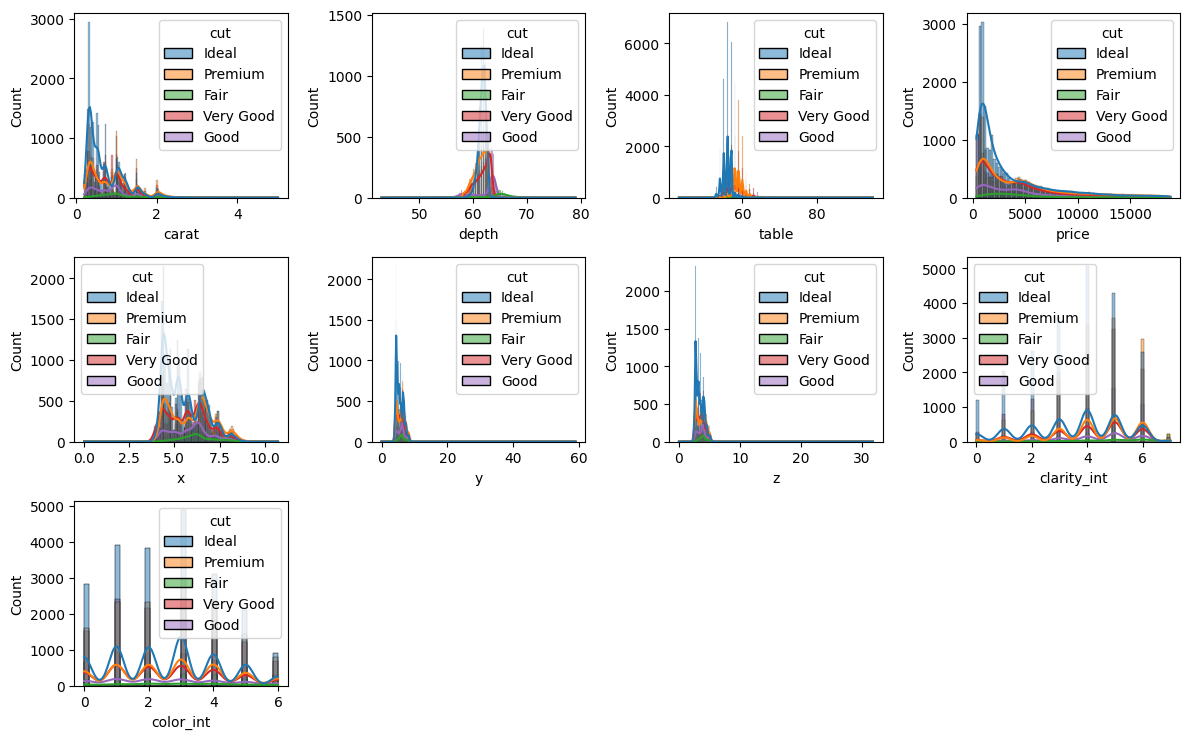

In [16]:
rdu.plot_histograms(diamonds, y_var='cut')

## Rozdělení na X a y, rozdělení na trénovací a testovací množinu

In [17]:
cuts_ordered = ['Ideal', 'Premium', 'Very Good', 'Good', 'Fair']

In [18]:
# rozdělení datasetu na X a y
X = diamonds.copy().drop(columns='cut')
y_cat = pd.Categorical(diamonds['cut'], ordered=True, categories=cuts_ordered)

In [19]:
y = y_cat.codes
labels = y_cat.categories

In [20]:
X.head()

,carat,depth,table,price,x,y,z,clarity_int,color_int
0,0.23,61.5,55.0,326,3.95,3.98,2.43,6,1
1,0.20,60.2,62.0,345,3.79,3.75,2.27,6,1
2,0.86,55.1,69.0,2757,6.45,6.33,3.52,6,1
3,0.74,62.2,56.0,2761,5.80,5.84,3.62,6,1
4,1.01,67.4,60.0,2797,6.19,6.05,4.13,6,1


In [21]:
y

array([0, 1, 4, ..., 0, 0, 2], dtype=int8)

In [22]:
labels

Index(['Ideal', 'Premium', 'Very Good', 'Good', 'Fair'], dtype='object')

In [23]:
# rozdělení na trénovací a testovací množinu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [24]:
# ověření datových typů
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   carat        53940 non-null  float64
 1   depth        53940 non-null  float64
 2   table        53940 non-null  float64
 3   price        53940 non-null  int64  
 4   x            53940 non-null  float64
 5   y            53940 non-null  float64
 6   z            53940 non-null  float64
 7   clarity_int  53940 non-null  int64  
 8   color_int    53940 non-null  int64  
dtypes: float64(6), int64(3)
memory usage: 3.7 MB


---

# Modelování

## Pomocná trénovcí funkce

In [25]:
def search_grid_and_print_score(estimator, param_distributions, X_train, X_test, y_train, y_test, cv=5, n_iter=20, scoring='accuracy'):
    """Natrénuje model na RandomizedSearchCV vč hledání hyperparametrů

    :param estimator: estimator nebo pipeline k natrénování
    :param param_distributions: síť hyperparametrů
    :param X_train:
    :param X_test:
    :param y_train:
    :param y_test:
    :param cv: parametr cv pro RandomizedSearchCV
    :param n_iter: parametr n_iter pro RandomizedSearchCV
    :param scoring: parametr scoring pro RandomizedSearchCV
    """
    # objekt RandomizedSearchCV
    search = RandomizedSearchCV(
        estimator=estimator, param_distributions=param_distributions, n_iter=n_iter,
        scoring=scoring, cv=cv, random_state=42, n_jobs=-1, verbose=5,error_score='raise')

    # nácvik modelu
    search.fit(X_train, y_train)

    # výsledky
    print("Best Parameters:", search.best_params_)
    print("Best CV Score:", np.round(search.best_score_, 3))
    print(f"Train score: {np.round(search.score(X_train, y_train), 3)}")
    print(f"Test score: {np.round(search.score(X_test, y_test), 3)}")

    return search

In [26]:
# používáme poměrně krátké trénování, aby netrvalo příliš dlouho
# v praxi bychom zvolili například cv=5 a n_iter=30
cv = 3
n_iter = 5
scoring = 'roc_auc_ovr_weighted'  # skórovací metrika

## Trénink modelů

### Decision tree

In [27]:
# decision tree pipeline
dt = make_pipeline(PolynomialFeatures(), DecisionTreeClassifier())

In [28]:
# síť hyperparametrů - decision tree
params_dt = {
    'polynomialfeatures__degree': [1, 2],
    'decisiontreeclassifier__criterion': ['gini', 'entropy'],
    'decisiontreeclassifier__min_samples_split': [2, 5, 10, 20],
    'decisiontreeclassifier__max_depth': [2, 5, 10, 15]
}

In [29]:
# dt.get_params()

In [30]:
model_dt = search_grid_and_print_score(dt, params_dt, X_train, X_test, y_train, y_test,
                                       cv=cv, n_iter=n_iter, scoring=scoring)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters: {'polynomialfeatures__degree': 1, 'decisiontreeclassifier__min_samples_split': 10, 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__criterion': 'entropy'}
Best CV Score: 0.885
Train score: 0.912
Test score: 0.894


### LGBMClassifier

In [31]:
from lightgbm import LGBMClassifier

In [32]:
# LGBMClassifier
lgbmc = make_pipeline(PolynomialFeatures(), LGBMClassifier(learning_rate=0.1, n_estimators=100, num_leaves=31))

In [33]:
lgbmc.get_params()

{'memory': None,
 'steps': [('polynomialfeatures', PolynomialFeatures()),
  ('lgbmclassifier', LGBMClassifier())],
 'verbose': False,
 'polynomialfeatures': PolynomialFeatures(),
 'lgbmclassifier': LGBMClassifier(),
 'polynomialfeatures__degree': 2,
 'polynomialfeatures__include_bias': True,
 'polynomialfeatures__interaction_only': False,
 'polynomialfeatures__order': 'C',
 'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': None,
 'lgbmclassifier__colsample_bytree': 1.0,
 'lgbmclassifier__importance_type': 'split',
 'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': -1,
 'lgbmclassifier__min_child_samples': 20,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__min_split_gain': 0.0,
 'lgbmclassifier__n_estimators': 100,
 'lgbmclassifier__n_jobs': None,
 'lgbmclassifier__num_leaves': 31,
 'lgbmclassifier__objective': None,
 'lgbmclassifier__random_state': None,
 'lgbmclassifier__reg_alpha': 0.0,
 'lgbmclassifier__reg_lambda': 0.0,
 'lgb

In [34]:
# síť hyperparametrů - lgbmc
params_lgbmc = {
    'lgbmclassifier__min_child_weight': [1, 5, 10],
    'lgbmclassifier__subsample': [0.6, 0.8, 1.0],
    'lgbmclassifier__colsample_bytree': [0.6, 0.8, 1.0],
    'lgbmclassifier__max_depth': [4, 5, 8],
    'lgbmclassifier__num_leaves': [5, 10, 15]
} # <-- STUDENT

In [35]:
model_lgbmc = search_grid_and_print_score(lgbmc, params_lgbmc, X_train, X_test, y_train, y_test,
                                        cv=cv, n_iter=n_iter, scoring=scoring)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024556 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11811
[LightGBM] [Info] Number of data points in the train set: 37758, number of used features: 54
[LightGBM] [Info] Start training from score -0.920817
[LightGBM] [Info] Start training from score -1.361859
[LightGBM] [Info] Start training from score -1.496321
[LightGBM] [Info] Start training from score -2.387619
[LightGBM] [Info] Start training from score -3.512526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

## Nápočet predikcí na testovací množině

In [36]:
# skutečné hodnoty y na testovací množině - převod na "labels"
y_test_labels = labels[y_test]
y_test_labels

Index(['Very Good', 'Good', 'Very Good', 'Very Good', 'Very Good', 'Ideal',
       'Ideal', 'Ideal', 'Very Good', 'Premium',
       ...
       'Premium', 'Premium', 'Premium', 'Ideal', 'Premium', 'Ideal', 'Premium',
       'Premium', 'Ideal', 'Ideal'],
      dtype='object', length=16182)

In [37]:
# predikovaná y na testovací množině - převod na "labels" - (viz lekci 9, část 2))
# výsledkem zde je obejkty typu numpy.ndarray o rozměrech (16182,), které obsahují predikované labels
# např.: array(['Ideal', 'Very Good', 'Ideal', ..., 'Premium', 'Premium', 'Ideal'], dtype=object)
y_pred_labels_dt = model_dt.predict(X_test)  # <-- STUDENT
y_pred_labels_lgbmc = model_lgbmc.predict(X_test)  # <-- STUDENT

In [38]:
y_pred_labels_dt[:10]

array([3, 3, 2, 1, 0, 0, 0, 0, 2, 1], dtype=int8)

In [39]:
y_pred_labels_lgbmc[:10]

array([3, 3, 2, 3, 0, 0, 0, 0, 2, 1], dtype=int8)

In [40]:
# predikce pravděpodobností na testovací množině - metoda .predict_proba()
# výsledkem zde je obejkty typu numpy.ndarray o rozměrech (16182, 5), které obsahují pravděpodobnosti predikcí jednotlivých tříd
y_pred_proba_dt = model_dt.predict_proba(X_test) # <-- STUDENT
y_pred_proba_lgbmc = model_lgbmc.predict_proba(X_test) # <-- STUDENT

# Matice záměn

## Decision tree

In [41]:
y_pred_labels_dt = labels[model_dt.predict(X_test).flatten()].values
y_pred_labels_dt

array(['Good', 'Good', 'Very Good', ..., 'Ideal', 'Ideal', 'Ideal'],
      dtype=object)

In [42]:
y_test_labels = labels[y_test].values
y_test_labels[:12]

array(['Very Good', 'Good', 'Very Good', 'Very Good', 'Very Good',
       'Ideal', 'Ideal', 'Ideal', 'Very Good', 'Premium', 'Ideal',
       'Ideal'], dtype=object)

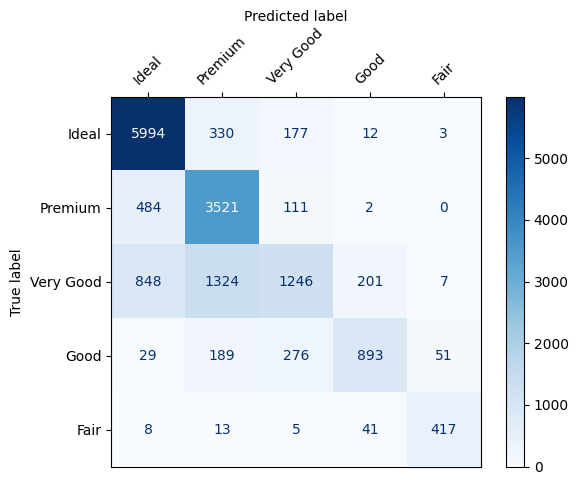

In [43]:
ax = ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels_dt, labels=labels, cmap=plt.cm.Blues).ax_
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(labels, rotation = 45);

## LGBM

In [44]:
y_pred_labels_lgbmc = labels[model_lgbmc.predict(X_test).flatten()].values
y_pred_labels_lgbmc

array(['Good', 'Good', 'Very Good', ..., 'Premium', 'Ideal', 'Ideal'],
      dtype=object)

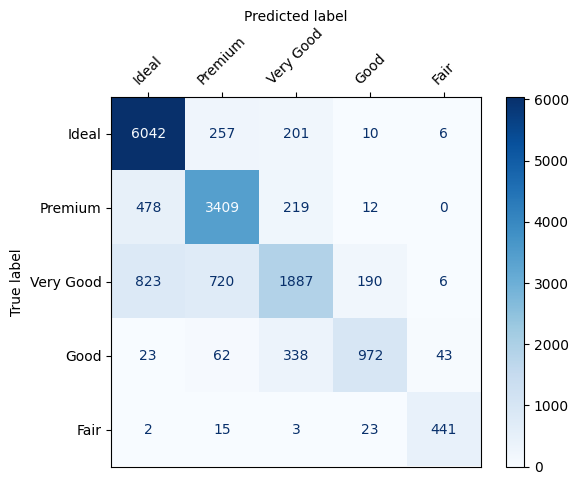

In [45]:
ax = ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels_lgbmc, labels=labels, cmap=plt.cm.Blues).ax_
ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.xaxis.set_label_position('top')
ax.set_xticklabels(labels, rotation = 45); # <STUDENT>

**ÚKOL:**

Porovnejte matice záměn obou modelů. Vyhledejte pro každý z modelů, za kterou jinou třídu došlo nejčastěji k záměně (chybě), když bylo skutečné porozování "Very Good".

**ODPOVĚĎ STUDENT**

- Decision tree: nejčasteji došlo k vymene za Premium (1324) pak za Ideal (848)
- LGBM Classifier: nejčasteji došlo k vymene za Ideal (823) a pak za Premium (720)

# Classification report

### Textový výstup, metoda `print()`

In [46]:
# classification_report pro decision tree
print(classification_report(y_test_labels, y_pred_labels_dt, labels=labels))

              precision    recall  f1-score   support

       Ideal       0.81      0.92      0.86      6516
     Premium       0.65      0.86      0.74      4118
   Very Good       0.69      0.34      0.46      3626
        Good       0.78      0.62      0.69      1438
        Fair       0.87      0.86      0.87       484

    accuracy                           0.75     16182
   macro avg       0.76      0.72      0.72     16182
weighted avg       0.74      0.75      0.73     16182



In [47]:
# classification_report pro lgbm
print(classification_report(y_test_labels, y_pred_labels_lgbmc,  labels=labels)) # <STUDENT>

              precision    recall  f1-score   support

       Ideal       0.82      0.93      0.87      6516
     Premium       0.76      0.83      0.79      4118
   Very Good       0.71      0.52      0.60      3626
        Good       0.81      0.68      0.73      1438
        Fair       0.89      0.91      0.90       484

    accuracy                           0.79     16182
   macro avg       0.80      0.77      0.78     16182
weighted avg       0.78      0.79      0.78     16182



**OTÁZKA**: Projděte classifiction reporty pro oba modely. Najdete nějakou metriku, pro kterou je Decision Tree lepší, než pro LGBM? Pokud ano, kterou?

**ODPOVĚĎ STUDENT:** DT je lepši jen v jednom pripradu a to pri metrice recall pri predikci Premium.

----

----

## `VE VŠECH DALŠÍCH ÚLOHÁCH PRACUJTE POUZE S VÝSTUPY MODELU LIGHTGBM`

----

----

### classification_report jako dictionary, parametr `output_dict`

Vytiskněte classification_report pro lgbmc. Použijte použijte parametr `output_dict` pro získání reportu jako dictionary.

In [48]:
classification_report(y_test_labels, y_pred_labels_lgbmc, output_dict=True) # <STUDENT>

{'Fair': {'precision': 0.8891129032258065,
  'recall': 0.9111570247933884,
  'f1-score': 0.9,
  'support': 484},
 'Good': {'precision': 0.8053024026512013,
  'recall': 0.6759388038942976,
  'f1-score': 0.7349716446124763,
  'support': 1438},
 'Ideal': {'precision': 0.8200325732899023,
  'recall': 0.927255985267035,
  'f1-score': 0.8703543647363873,
  'support': 6516},
 'Premium': {'precision': 0.7638359847636119,
  'recall': 0.8278290432248664,
  'f1-score': 0.7945460901992775,
  'support': 4118},
 'Very Good': {'precision': 0.7126132930513596,
  'recall': 0.5204081632653061,
  'f1-score': 0.6015301243226012,
  'support': 3626},
 'accuracy': 0.7879742924236807,
 'macro avg': {'precision': 0.7981794313963764,
  'recall': 0.7725178040889787,
  'f1-score': 0.7802804447741485,
  'support': 16182},
 'weighted avg': {'precision': 0.782418745123687,
  'recall': 0.7879742924236807,
  'f1-score': 0.7796815780379073,
  'support': 16182}}

---

# ROC AUC skóre

Zdroje:

- lekce 3
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
- https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics
- https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a

### macro-averaged

Vypočítejte macro-averaged ROC AUC skóre pomocí funkce `roc_auc_score`. Vstupní data jsou `y_test` a `y_pred_proba_lgbmc`. Dále použijte parametry `average='macro', multi_class='ovr'`.

In [49]:
# macor-averaged ROC AUC skóre
roc_auc_score_macro = roc_auc_score(y_test, y_pred_proba_lgbmc, average='macro', multi_class='ovr')  # <-- STUDENT
roc_auc_score_macro

0.9432845005724791

### bez průměrování (parametr `average='None'`)

In [50]:
# ROC AUC skóre nez průměrování
roc_auc_ovr_none = roc_auc_score(y_test, y_pred_proba_lgbmc, average= None, multi_class='ovr')  # <-- STUDENT
roc_auc_ovr_none

array([0.94640589, 0.95141521, 0.86300965, 0.96914022, 0.98645153])

In [51]:
# vypočtěte průměr hodnot roc_auc_ovr_none
def mean(numbers):
  return float(sum(numbers)) / max(len(numbers), 1)

mean(roc_auc_ovr_none) # <STUDENT>

0.9432845005724791

**ÚKOL:**

- Proč je výsledkem `roc_auc_ovr_none` více hodnot, a ne jenom jedna? Co každá z těchto hodnot říká?
- Jaké metrice odpovídá vypočtený průměr těchto hodnot?

**ODPOVĚĎI STUDENT**

Protože se vypočíta ROC AUC pro každou z tridy CUT. AUC je meritko vykonu krivky ROC. Pokud je AUC 1 tak všechny predikce jsou 100% correct. V tomhle pripade je zprumerovane AUC 0.94 což je vysoka presnost predikce.

# ROC křivka

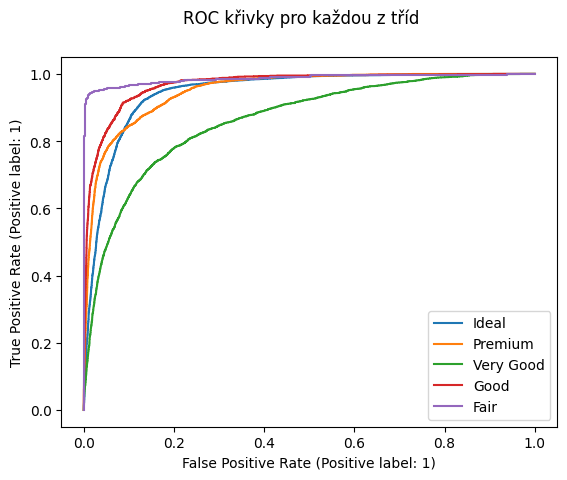

In [52]:
fig, ax = plt.subplots()
for class_pos in range(5):
    y_class = (y_test==class_pos).astype(int)
    scores = y_pred_proba_lgbmc[:, class_pos]
    RocCurveDisplay.from_predictions(y_class, scores, ax=ax, label=labels[class_pos])
plt.suptitle('ROC křivky pro každou z tříd');

**ÚKOL:**

Projděte znovu všechny metody vyhodnocení, které jsme vypočetli výše:

- matice záměn
- classification report
- ROC AUC skóre (neprůměrované)
- ROC křivka

Pro jednu ze tříd je model výrazně horší, než pro ostatní. Pro kterou? Vyberte alespoň dva nástroje pro vyhodnocení ze seznamu výše a napište, na základě čeho tak usuzujete (tedy jak jste tento nástroj použili pro identifikaci "horší" třídy).

**ODPOVĚĎI STUDENT**
 Pro Very Good. Usuzujem z ROC AUC score kde hodnota pre tridu Very good je menej ako 0.9. Take usuzuji z classification reportu kde f1 score je najnižsi pro tridu Verz Goods. Take z matice zamen je videt, že pri tride Very goods došlo k nejčastejšie k nespravne predikci.

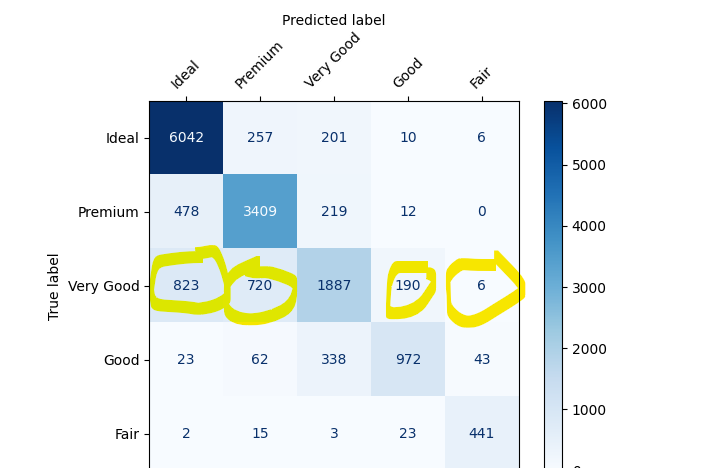